In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## Original Dataset

In [110]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv',
                      skiprows=[0,1,2,3])
raw_data.columns =['city',
                   'population',
                   'violent_crime',
                   'murder',
                   'rape_def_1',
                   'rape_def_2',
                  'robbery',
                  'aggravated_assault',
                  'property_crime',
                  'burglary',
                  'larceny_theft',
                  'motor_vehicle_theft',
                  'arson']

#set dataframe
df = raw_data[['city', 'population']].copy()

#get population^2 variable
df = df.dropna(axis=0, subset=['population']) #drop nan values
df['population'] = df['population'].str.replace(',', '') #get rid of commas
df['population'] = df['population'].astype(str).astype(int) #from object cast to string then int
df['population_sq'] = df['population'] ** 2 #square column and put in new column

#add other desired variables
df['murder'], df['robbery'] = raw_data['murder'], raw_data['robbery']
df.head()

#prepare murder and robbery to be iterated on
df['murder'] = df['murder'].astype(int)
df['robbery'] = df['robbery'].str.replace(',', '')
df['robbery'] = df['robbery'].astype(int)

#change values to 0 or 1 for multivariable regression
df.loc[df['murder'] > 0, ['murder']] = 1
df.loc[df['robbery'] > 0, ['robbery']] = 1

#add property crime variable
df['property_crime'] = raw_data['property_crime']
df['property_crime'] = df['property_crime'].str.replace(',', '') #get rid of commas
df['property_crime'] = df['property_crime'].astype(int)

#add some more variables for new regression
df['burglary'] = raw_data['burglary'].str.replace(',','')
df['burglary'] = df['burglary'].astype(int)
df.loc[df['burglary'] > 0, ['burglary']] = 1

df['motor_vehicle_theft'] = raw_data['motor_vehicle_theft'].str.replace(',','')
df['motor_vehicle_theft'] = df['motor_vehicle_theft'].astype(int)
df.loc[df['motor_vehicle_theft'] > 0, ['motor_vehicle_theft']] = 1

df['rape_def_2'] = raw_data['rape_def_2'].str.replace(',','')
df['rape_def_2'] = df['rape_def_2'].astype(int)
df.loc[df['rape_def_2'] > 0, ['rape_def_2']] = 1

df.head()

,city,population,population_sq,murder,robbery,property_crime,burglary,motor_vehicle_theft,rape_def_2
0,Adams Village,1861,3463321,0,0,12,1,0,0
1,Addison Town and Village,2577,6640929,0,0,24,1,1,0
2,Akron Village,2846,8099716,0,0,16,1,0,0
3,Albany,97956,9595377936,1,1,4090,1,1,1
4,Albion Village,6388,40806544,0,1,223,1,1,1


In [143]:
#use regression that eliminated the population feature

regr = linear_model.LinearRegression()
Y = df['property_crime'].values.reshape(-1,1)
X = df[['population','murder','rape_def_2']]
regr.fit(X,Y)

#inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

correlation_matrix = X.corr()
display(correlation_matrix)


Coefficients: 
 [[1.68695732e-02 5.63583047e+02 1.69854957e+02]]

Intercept: 
 [-32.45134063]

R-squared:
0.9935083799278801


,population,murder,rape_def_2
population,1.000,0.162,0.087
murder,0.162,1.000,0.381
rape_def_2,0.087,0.381,1.000


In [142]:
linear_formula = 'property_crime ~ population+murder+rape_def_2'
lm = smf.ols(formula=linear_formula, data=df).fit()

lm.params

Intercept    -32.451
population     0.017
murder       563.583
rape_def_2   169.855
dtype: float64

In [144]:
lm.pvalues

Intercept    0.456
population   0.000
murder       0.000
rape_def_2   0.021
dtype: float64

In [145]:
lm.rsquared

0.9935083799278802

In [146]:
lm.conf_int()

,0,1
Intercept,-118.018,53.115
population,0.017,0.017
murder,358.321,768.845
rape_def_2,26.270,313.440


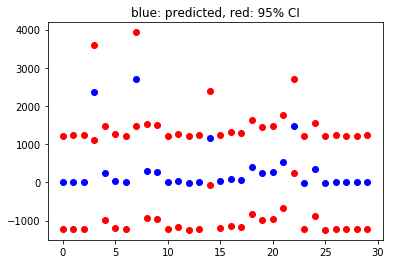

In [182]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:30], 'o', color='r')
plt.plot(iv_l[0:30], 'o', color='r')
plt.plot(lm.fittedvalues[0:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X,Y).score(X,Y)))

#from sklearn.model_selection import cross_val_score
#cross_val_score(regr, data, target, cv=5)

With 20% Holdout: 0.6370699252352712
Testing on Sample: 0.9935083799278801


## Test on new datasets

In [10]:
#crime data for Illinois 2013
IL_2013_raw = pd.read_excel('table_8_offenses_known_to_law_enforcement_illinois_by_city_2013.xls',
                       skiprows=[0,1,2,3])
IL_2013_raw.columns =['city',
                   'population',
                   'violent_crime',
                   'murder',
                   'rape_def_1',
                   'rape_def_2',
                  'robbery',
                  'aggravated_assault',
                  'property_crime',
                  'burglary',
                  'larceny_theft',
                  'motor_vehicle_theft',
                  'arson']

IL_2013_raw = pd.DataFrame(IL_2013_raw)
IL_2013_raw.head()

,city,population,violent_crime,murder,rape_def_1,rape_def_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
0,Addison,37378.000,40.000,1.000,nan,8.000,5.000,26.000,640.000,97.000,527.000,16.000,5.000
1,Albany,878.000,0.000,0.000,nan,0.000,0.000,0.000,5.000,0.000,5.000,0.000,0.000
2,Albers,1187.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,Albion,1975.000,0.000,0.000,nan,0.000,0.000,0.000,33.000,8.000,22.000,3.000,1.000
4,Algonquin,29980.000,18.000,0.000,nan,3.000,2.000,13.000,519.000,33.000,475.000,11.000,6.000


In [167]:
#prepare dataframe for regression
IL_2013 = IL_2013_raw[['city', 'population']].copy()

#get population^2 variable
IL_2013 = IL_2013.dropna(axis=0, subset=['population']) #drop nan values
IL_2013['population_sq'] = IL_2013['population'] ** 2 #square column and put in new column

#add other desired variables
IL_2013['murder'], IL_2013['robbery'] = IL_2013_raw['murder'], IL_2013_raw['robbery']

#prepare murder and robbery to be iterated on
IL_2013['murder'] = IL_2013['murder'].astype(int)
IL_2013['robbery'] = IL_2013['robbery'].astype(int)

#change values to 0 or 1 for multivariable regression
IL_2013.loc[IL_2013['murder'] > 0, ['murder']] = 1
IL_2013.loc[IL_2013['robbery'] > 0, ['robbery']] = 1

#add property crime variable
IL_2013['property_crime'] = IL_2013_raw['property_crime']
IL_2013['property_crime'] = IL_2013['property_crime'].astype(int)

#add some more variables for new regression
IL_2013['burglary'] = IL_2013_raw['burglary']
IL_2013['burglary'] = IL_2013['burglary'].astype(int)
IL_2013.loc[IL_2013['burglary'] > 0, ['burglary']] = 1

IL_2013['rape_def_2'] = IL_2013_raw['rape_def_2']
IL_2013 = IL_2013.dropna(axis=0, subset=['rape_def_2'])
IL_2013['rape_def_2'] = IL_2013['rape_def_2'].astype(int)
IL_2013.loc[IL_2013['rape_def_2'] > 0, ['rape_def_2']] = 1

IL_2013.head()

,city,population,population_sq,murder,robbery,property_crime,burglary,rape_def_2
0,Addison,37378.000,1397114884.000,1,1,640,1,1
1,Albany,878.000,770884.000,0,0,5,0,0
2,Albers,1187.000,1408969.000,0,0,0,0,0
3,Albion,1975.000,3900625.000,0,0,33,1,0
4,Algonquin,29980.000,898800400.000,0,1,519,1,1


In [168]:
#run model
IL_regr = IL_2013[['population_sq','murder','robbery','property_crime','rape_def_2']].copy()

Y_IL = IL_regr['property_crime'].values.reshape(-1,1)
X_IL = IL_regr[['population_sq','murder','rape_def_2']]
regr.fit(X_IL,Y_IL)

#inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_IL, Y_IL))

correlation_matrix = X_IL.corr()
display(correlation_matrix)


Coefficients: 
 [[1.28001349e-07 2.41141258e+02 2.08014955e+02]]

Intercept: 
 [55.95801742]

R-squared:
0.6047841239458587


,population_sq,murder,rape_def_2
population_sq,1.000,0.297,0.209
murder,0.297,1.000,0.327
rape_def_2,0.209,0.327,1.000


In [170]:
X_train, X_test, y_train, y_test = train_test_split(X_IL, Y_IL, test_size=0.2)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X_IL,Y_IL).score(X_IL, Y_IL)))

#cross_val_score(regr,X_IL,Y_IL,cv=5)

With 20% Holdout: 0.6095157626524301
Testing on Sample: 0.6047841239458587


In [171]:
linear_formula = 'property_crime ~ population_sq+murder+rape_def_2'
lm_IL_2013 = smf.ols(formula=linear_formula, data=IL_regr).fit()

lm_IL_2013.params

Intercept        55.958
population_sq     0.000
murder          241.141
rape_def_2      208.015
dtype: float64

In [172]:
lm_IL_2013.pvalues

Intercept       0.011
population_sq   0.000
murder          0.000
rape_def_2      0.000
dtype: float64

In [173]:
lm_IL_2013.rsquared

0.6047841239458587

In [17]:
#crime data for New York 2014
NY_2014_raw = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls',
                       skiprows=[0,1,2,3])
NY_2014_raw.columns =['city',
                   'population',
                   'violent_crime',
                   'murder',
                   'rape_def_1',
                   'rape_def_2',
                  'robbery',
                  'aggravated_assault',
                  'property_crime',
                  'burglary',
                  'larceny_theft',
                  'motor_vehicle_theft',
                  'arson']

NY_2014_raw = pd.DataFrame(NY_2014_raw)
NY_2014_raw.head()

,city,population,violent_crime,murder,rape_def_1,rape_def_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
0,Adams Village,1851.000,0.000,0.000,nan,0.000,0.000,0.000,11.000,1.000,10.000,0.000,0.000
1,Addison Town and Village,2568.000,2.000,0.000,nan,0.000,1.000,1.000,49.000,1.000,47.000,1.000,0.000
2,Afton Village4,820.000,0.000,0.000,0.000,nan,0.000,0.000,1.000,0.000,1.000,0.000,0.000
3,Akron Village,2842.000,1.000,0.000,nan,0.000,0.000,1.000,17.000,0.000,17.000,0.000,0.000
4,Albany4,98595.000,802.000,8.000,54.000,nan,237.000,503.000,3888.000,683.000,3083.000,122.000,12.000


In [175]:
#prepare dataframe for regression. this time leaving murder & robbery in their true values
NY_2014 = NY_2014_raw[['city', 'population']].copy()

#get population^2 variable
NY_2014 = NY_2014.dropna(axis=0, subset=['population']) #drop nan values
NY_2014['population_sq'] = NY_2014['population'] ** 2 #square column and put in new column

#add other desired variables
NY_2014['murder'], NY_2014['robbery'] = NY_2014_raw['murder'], NY_2014_raw['robbery']

#prepare murder and robbery to be iterated on
NY_2014['murder'] = NY_2014['murder'].astype(int)
NY_2014['robbery'] = NY_2014['robbery'].astype(int)

#change values to 0 or 1 for multivariable regression
NY_2014.loc[NY_2014['murder'] > 0, ['murder']] = 1
NY_2014.loc[NY_2014['robbery'] > 0, ['robbery']] = 1

#add property crime variable
NY_2014['property_crime'] = NY_2014_raw['property_crime']
NY_2014 = NY_2014.dropna(axis=0, subset=['property_crime'])
NY_2014['property_crime'] = NY_2014['property_crime'].astype(int)

NY_2014['rape_def_2'] = NY_2014_raw['rape_def_2']
NY_2014 = NY_2014.dropna(axis=0, subset=['rape_def_2'])
NY_2014['rape_def_2'] = NY_2014['rape_def_2'].astype(int)
NY_2014.loc[NY_2014['rape_def_2'] > 1, ['rape_def_2']] = 1

NY_2014.head()

,city,population,population_sq,murder,robbery,property_crime,rape_def_2
0,Adams Village,1851.000,3426201.000,0,0,11,0
1,Addison Town and Village,2568.000,6594624.000,0,1,49,0
3,Akron Village,2842.000,8076964.000,0,0,17,0
11,Amityville Village,9509.000,90421081.000,0,1,198,0
12,Amsterdam,18099.000,327573801.000,0,1,490,0


In [176]:
#run model
NY_2014_regr = NY_2014[['population_sq','murder','robbery','property_crime','rape_def_2']].copy()

Y_NY_2014 = NY_2014_regr['property_crime'].values.reshape(-1,1)
X_NY_2014 = NY_2014_regr[['population_sq','murder','rape_def_2']]
regr.fit(X_NY_2014,Y_NY_2014)

#inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_NY_2014, Y_NY_2014))

correlation_matrix = X_NY_2014.corr()
display(correlation_matrix)


Coefficients: 
 [[ 4.69584815e-07  1.40358380e+02 -2.73441209e+02]]

Intercept: 
 [39.81204911]

R-squared:
0.6783774202728625


,population_sq,murder,rape_def_2
population_sq,1.000,0.552,0.105
murder,0.552,1.000,0.255
rape_def_2,0.105,0.255,1.000


In [177]:
lm_NY_2014 = smf.ols(formula=linear_formula, data=NY_2014_regr).fit()

lm_NY_2014.params

Intercept         39.812
population_sq      0.000
murder           140.358
rape_def_2      -273.441
dtype: float64

In [178]:
lm_NY_2014.pvalues

Intercept       0.003
population_sq   0.000
murder          0.006
rape_def_2      0.073
dtype: float64

In [179]:
lm_NY_2014.rsquared

0.6783774202728625

In [188]:
lm_NY_2014.conf_int()

,0,1
Intercept,13.589,66.035
population_sq,0.000,0.000
murder,40.364,240.353
rape_def_2,-572.370,25.488


In [189]:
X_train, X_test, y_train, y_test = train_test_split(X_NY_2014, Y_NY_2014, test_size=0.2)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X_NY_2014,Y_NY_2014).score(X_NY_2014, Y_NY_2014)))

With 20% Holdout: 0.6370081721246255
Testing on Sample: 0.6783774202728625
